"""
═══════════════════════════════════════════════════════════════════════════════
NOTEBOOK 1: Train BAD Classifier & Save to HuggingFace Hub
═══════════════════════════════════════════════════════════════════════════════

This notebook:
1. Trains a BAD (Biased Activation Detection) classifier
2. Saves it to HuggingFace Hub for easy sharing and reuse
3. Creates a model card with documentation

Author: David Bong
Date: 2025
Paper: FairSteer - Inference Time Debiasing for LLMs
═══════════════════════════════════════════════════════════════════════════════
"""

# SECTION 1: Installation & Setup

In [1]:
print("📦 Installing required packages...")

!pip install -q transformers datasets torch accelerate huggingface_hub tqdm scikit-learn matplotlib seaborn

print("✅ Installation complete!\n")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from tqdm.auto import tqdm
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from huggingface_hub import HfApi, create_repo, login
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("🎯 BAD Classifier Training (FIXED VERSION)")
print("="*80)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*80 + "\n")


📦 Installing required packages...
✅ Installation complete!

🎯 BAD Classifier Training (FIXED VERSION)
Device: cuda
GPU: Tesla T4



# SECTION 2: Configuration

In [2]:
class TrainingConfig:
    """Training configuration following FairSteer paper"""

    # Model
    base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    max_length = 256

    # Dataset - Following Paper
    bbq_dataset_name = "bitlabsdb/BBQ_dataset"  # or "nyu-mll/BBQ"
    mmlu_dataset_name = "cais/mmlu"

    num_bbq_samples = 58942  # Subset for demo (paper uses 58,492)
    num_mmlu_samples = 20266  # Subset for demo (paper uses 10,266)
    train_val_split = 0.8

    # Training
    batch_size = 32
    num_epochs = 50  # Increased for better convergence
    learning_rate = 1e-3  # ✅ FIX #2: Reduced from 1e-2 to 1e-3
    weight_decay = 1e-2
    early_stopping_patience = 15  # Increased patience

    #  Gradient clipping
    gradient_clip_norm = 1.0

    # Test multiple layers
    layer_selection_strategy = "optimal"
    candidate_layers_range = [11, 12, 13, 14, 15, 16]  # Test 6 layers

    # Labels
    LABEL_BIASED = 0
    LABEL_UNBIASED = 1

    # Class weighting enabled
    use_class_weights = True

    # HuggingFace
    hf_repo_name = "bitlabsdb/bad-classifier-tinyllama"
    hf_private = False

    # Local
    local_save_dir = "./bad_model_fixed"

config = TrainingConfig()

print("⚙️  Configuration (FIXED):")
print("="*80)
print(f"Learning Rate:      {config.learning_rate} ✅ (was 1e-2)")
print(f"Gradient Clipping:  {config.gradient_clip_norm} ✅ (new)")
print(f"Class Weights:      {config.use_class_weights} ✅ (new)")
print(f"Candidate Layers:   {config.candidate_layers_range} ✅ (was [14])")
print(f"Early Stop Patience: {config.early_stopping_patience} ✅")
print("="*80 + "\n")

⚙️  Configuration (FIXED):
Learning Rate:      0.001 ✅ (was 1e-2)
Gradient Clipping:  1.0 ✅ (new)
Class Weights:      True ✅ (new)
Candidate Layers:   [11, 12, 13, 14, 15, 16] ✅ (was [14])
Early Stop Patience: 15 ✅



# SECTION 3: BAD Classifier Architecture

In [3]:
class BADClassifier(nn.Module):
    """
    Biased Activation Detection Classifier
    Output: [logit_biased, logit_unbiased]
    Index 0 → P(biased)
    Index 1 → P(unbiased)
    """

    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.input_dim = input_dim


        self.LABEL_BIASED = 0
        self.LABEL_UNBIASED = 1

    def forward(self, x):
        """Returns logits: [logit_biased, logit_unbiased]"""
        return self.linear(x)

    def predict_proba(self, x):
        """
        Returns probability distribution

        Output shape: (batch_size, 2)
        probs[:, 0] = P(biased)
        probs[:, 1] = P(unbiased)
        """
        logits = self.forward(x)
        return torch.softmax(logits, dim=-1)

    def predict_bias_probability(self, x):
        """
        Get P(biased)

        VERIFIED: probs[:, 0] corresponds to P(class=0) = P(biased)
        """
        probs = self.predict_proba(x)
        return probs[:, 0]  # P(biased)

    def predict_unbiased_probability(self, x):
        """
        Get P(unbiased)

        VERIFIED: probs[:, 1] corresponds to P(class=1) = P(unbiased)
        """
        probs = self.predict_proba(x)
        return probs[:, 1]  # P(unbiased)

    def detect_bias(self, x, threshold: float = 0.5):
        """
        Detect bias following paper convention

        Paper: Intervene when y^ < 0.5 where y^ = P(unbiased)
        Equivalently: Intervene when P(biased) > 0.5

        Args:
            x: Hidden state tensor
            threshold: Default 0.5 as per paper

        Returns:
            is_biased: True if P(biased) > threshold
            bias_prob: P(biased)
        """
        bias_prob = self.predict_bias_probability(x)
        is_biased = bias_prob > threshold
        return is_biased, bias_prob

print("✅ BAD Classifier defined with explicit label mapping\n")

✅ BAD Classifier defined with explicit label mapping



# SECTION 4: Dataset Loading with BBQ + MMLU (FIXED)

In [4]:
def load_bbq_dataset(config: TrainingConfig) -> Tuple[List[str], List[int]]:
    """

    BBQ Dataset Structure:
    - context: Background text
    - question: The question being asked
    - ans0, ans1, ans2: Three answer options
    - label: Index of correct answer (0, 1, or 2)
    - question_polarity: "neg" (negative stereotype) or "nonneg" (non-negative)

    Label Logic (Following Paper):
    - If the answer is "Unknown/Cannot determine" → UNBIASED (label=1)
    - If the answer is a specific person/group → BIASED (label=0)

    BBQ Format: The "Unknown" option is typically answer index 2 (ans2),
    but we verify this by checking for keywords like "Unknown", "Cannot",
    "Not enough", "Insufficient" in the answer text.
    """

    print("="*80)
    print("📚 Loading BBQ Dataset (FIXED)")
    print("="*80 + "\n")

    try:
        dataset = load_dataset(config.bbq_dataset_name)
        print(f"✅ Loaded BBQ dataset: {config.bbq_dataset_name}")
    except:
        try:
            dataset = load_dataset("nyu-mll/BBQ")
            print(f"✅ Loaded BBQ dataset: nyu-mll/BBQ")
        except Exception as e:
            print(f"❌ Could not load BBQ: {e}")
            return [], []

    # Get train split
    train_split = dataset['train']
    total_available = len(train_split)
    num_to_load = min(config.num_bbq_samples, total_available)

    print(f"   Total available: {total_available:,}")
    print(f"   Loading: {num_to_load:,} samples\n")

    # Slice dataset
    train_split = train_split.select(range(num_to_load))

    prompts = []
    labels = []


    unknown_keywords = ['unknown', 'cannot', 'not enough', 'insufficient',
                       'not answerable', 'undetermined', "can't"]

    label_distribution = {'by_index': {0: 0, 1: 0, 2: 0},
                         'by_content': {'unknown': 0, 'specific': 0}}

    print("Processing BBQ examples...")
    for example in tqdm(train_split, desc="Processing BBQ"):
        try:
            context = example.get('context', '')
            question = example.get('question', '')
            ans0 = example.get('ans0', '')
            ans1 = example.get('ans1', '')
            ans2 = example.get('ans2', '')

            if not all([question, ans0, ans1, ans2]):
                continue

            # Format prompt
            prompt = f"{context} {question}\nA. {ans0}\nB. {ans1}\nC. {ans2}\nAnswer:"


            label_idx = example.get('label', -1)

            if label_idx == -1:
                continue

            # Track label index distribution
            label_distribution['by_index'][label_idx] = \
                label_distribution['by_index'].get(label_idx, 0) + 1

            # Get the actual answer text
            answers = [ans0, ans1, ans2]
            selected_answer = answers[label_idx] if 0 <= label_idx < 3 else ""

            # Check if answer contains "unknown" keywords (case-insensitive)
            answer_lower = selected_answer.lower()
            is_unknown = any(keyword in answer_lower for keyword in unknown_keywords)

            # Label assignment following paper:
            # Unknown answer → Unbiased (1)
            # Specific answer → Biased (0)
            if is_unknown:
                label = config.LABEL_UNBIASED  # 1
                label_distribution['by_content']['unknown'] += 1
            else:
                label = config.LABEL_BIASED  # 0
                label_distribution['by_content']['specific'] += 1

            prompts.append(prompt)
            labels.append(label)

        except Exception as e:
            continue

    print(f"\n✅ Loaded {len(prompts)} BBQ examples")


    print(f"\n📊 BBQ Label Distribution Verification:")
    print(f"   By answer index:")
    for idx, count in label_distribution['by_index'].items():
        print(f"      Index {idx}: {count} ({count/len(prompts)*100:.1f}%)")

    print(f"\n   By content analysis:")
    print(f"      Unknown answers (Unbiased=1): {label_distribution['by_content']['unknown']} "
          f"({label_distribution['by_content']['unknown']/len(prompts)*100:.1f}%)")
    print(f"      Specific answers (Biased=0): {label_distribution['by_content']['specific']} "
          f"({label_distribution['by_content']['specific']/len(prompts)*100:.1f}%)")

    return prompts, labels

def load_mmlu_dataset(config: TrainingConfig) -> Tuple[List[str], List[int]]:
    """
    Load MMLU dataset following paper specifications

    Paper Requirements:
    1. Load MMLU dataset
    2. Remove all examples where correct answer is D
    3. Remove option D from remaining examples
    4. Label ALL MMLU examples as UNBIASED (label=1)

    Rationale: MMLU provides factual knowledge questions without social bias,
    helping prevent the classifier from overfitting to domain-specific artifacts.

    MMLU HuggingFace: cais/mmlu
    """

    print("="*80)
    print("📚 Loading MMLU Dataset (NEW - Following Paper)")
    print("="*80 + "\n")

    try:
        # Load MMLU dataset
        dataset = load_dataset(config.mmlu_dataset_name, 'all')
        print(f"✅ Loaded MMLU dataset: {config.mmlu_dataset_name}")
    except Exception as e:
        print(f"❌ Could not load MMLU: {e}")
        print("Continuing without MMLU (not recommended)")
        return [], []

    prompts = []
    labels = []

    # Process splits
    count = 0
    target = config.num_mmlu_samples

    for split_name in ['test', 'validation', 'dev']:
        if split_name not in dataset or count >= target:
            break

        print(f"   Processing '{split_name}' split...")

        for example in tqdm(dataset[split_name], desc=f"Processing MMLU {split_name}"):
            if count >= target:
                break

            try:
                question = example.get('question', '')
                choices = example.get('choices', [])
                answer_idx = example.get('answer', -1)

                # ✅ Skip if answer is D (index 3)
                if answer_idx == 3:
                    continue

                # ✅ Must have at least 3 choices (A, B, C)
                if len(choices) < 3:
                    continue

                # ✅ Format with only A, B, C (remove D)
                prompt = (f"{question}\n"
                         f"A. {choices[0]}\n"
                         f"B. {choices[1]}\n"
                         f"C. {choices[2]}\n"
                         f"Answer:")

                # ✅ ALL MMLU labeled as UNBIASED (following paper)
                label = config.LABEL_UNBIASED  # 1

                prompts.append(prompt)
                labels.append(label)
                count += 1

            except Exception as e:
                continue

    print(f"\n✅ Loaded {len(prompts)} MMLU examples")
    print(f"   All labeled as UNBIASED (label={config.LABEL_UNBIASED})")
    print(f"   Examples with answer D: excluded")
    print(f"   Options: A, B, C only (D removed)")

    return prompts, labels

def create_combined_dataset(config: TrainingConfig) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Create combined BAD dataset: BBQ + MMLU

    ✅ Following paper specification
    """

    print("\n" + "="*80)
    print("🔗 Creating Combined BAD Dataset (BBQ + MMLU)")
    print("="*80 + "\n")

    # Load BBQ
    bbq_prompts, bbq_labels = load_bbq_dataset(config)

    # Load MMLU
    mmlu_prompts, mmlu_labels = load_mmlu_dataset(config)

    # Combine
    all_prompts = bbq_prompts + mmlu_prompts
    all_labels = bbq_labels + mmlu_labels

    print(f"\n" + "="*80)
    print("📊 Combined Dataset Statistics")
    print("="*80)
    print(f"BBQ examples:   {len(bbq_prompts):,}")
    print(f"MMLU examples:  {len(mmlu_prompts):,}")
    print(f"Total examples: {len(all_prompts):,}")

    # Convert to arrays
    prompts_array = np.array(all_prompts, dtype=object)
    labels_array = np.array(all_labels, dtype=np.int32)

    # Distribution
    unique, counts = np.unique(labels_array, return_counts=True)
    print(f"\n📊 Combined Label Distribution:")
    for lbl, cnt in zip(unique, counts):
        label_name = "Unbiased" if lbl == 1 else "Biased"
        print(f"   {label_name} ({lbl}): {cnt:,} ({cnt/len(labels_array)*100:.1f}%)")

    # Shuffle
    indices = np.random.permutation(len(prompts_array))
    prompts_array = prompts_array[indices]
    labels_array = labels_array[indices]

    # Train/Val split with stratification
    train_prompts, val_prompts, train_labels, val_labels = train_test_split(
        prompts_array,
        labels_array,
        test_size=1-config.train_val_split,
        random_state=SEED,
        stratify=labels_array
    )

    print(f"\n📑 Data Split:")
    print(f"   Training:   {len(train_prompts):,} samples")
    print(f"   Validation: {len(val_prompts):,} samples")

    # Verify distributions
    train_unique, train_counts = np.unique(train_labels, return_counts=True)
    val_unique, val_counts = np.unique(val_labels, return_counts=True)

    print(f"\n   Train distribution:")
    for lbl, cnt in zip(train_unique, train_counts):
        print(f"     Label {lbl}: {cnt:,} ({cnt/len(train_labels)*100:.1f}%)")

    print(f"   Val distribution:")
    for lbl, cnt in zip(val_unique, val_counts):
        print(f"     Label {lbl}: {cnt:,} ({cnt/len(val_labels)*100:.1f}%)")

    print("="*80 + "\n")

    return train_prompts, train_labels, val_prompts, val_labels

# ✅ Load combined dataset
train_prompts, train_labels, val_prompts, val_labels = create_combined_dataset(config)


🔗 Creating Combined BAD Dataset (BBQ + MMLU)

📚 Loading BBQ Dataset (FIXED)



README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Age.jsonl: 0.00B [00:00, ?B/s]

Disability_status.jsonl: 0.00B [00:00, ?B/s]

Gender_identity.jsonl: 0.00B [00:00, ?B/s]

Nationality.jsonl: 0.00B [00:00, ?B/s]

Physical_appearance.jsonl: 0.00B [00:00, ?B/s]

Race_ethnicity.jsonl: 0.00B [00:00, ?B/s]

Race_x_SES.jsonl:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

Race_x_gender.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Religion.jsonl: 0.00B [00:00, ?B/s]

SES.jsonl: 0.00B [00:00, ?B/s]

Sexual_orientation.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/58492 [00:00<?, ? examples/s]

✅ Loaded BBQ dataset: bitlabsdb/BBQ_dataset
   Total available: 58,492
   Loading: 58,492 samples

Processing BBQ examples...


Processing BBQ:   0%|          | 0/58492 [00:00<?, ?it/s]


✅ Loaded 58492 BBQ examples

📊 BBQ Label Distribution Verification:
   By answer index:
      Index 0: 19469 (33.3%)
      Index 1: 19509 (33.4%)
      Index 2: 19514 (33.4%)

   By content analysis:
      Unknown answers (Unbiased=1): 26332 (45.0%)
      Specific answers (Biased=0): 32160 (55.0%)
📚 Loading MMLU Dataset (NEW - Following Paper)



README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

✅ Loaded MMLU dataset: cais/mmlu
   Processing 'test' split...


Processing MMLU test:   0%|          | 0/14042 [00:00<?, ?it/s]

   Processing 'validation' split...


Processing MMLU validation:   0%|          | 0/1531 [00:00<?, ?it/s]

   Processing 'dev' split...


Processing MMLU dev:   0%|          | 0/285 [00:00<?, ?it/s]


✅ Loaded 11620 MMLU examples
   All labeled as UNBIASED (label=1)
   Examples with answer D: excluded
   Options: A, B, C only (D removed)

📊 Combined Dataset Statistics
BBQ examples:   58,492
MMLU examples:  11,620
Total examples: 70,112

📊 Combined Label Distribution:
   Biased (0): 32,160 (45.9%)
   Unbiased (1): 37,952 (54.1%)

📑 Data Split:
   Training:   56,089 samples
   Validation: 14,023 samples

   Train distribution:
     Label 0: 25,728 (45.9%)
     Label 1: 30,361 (54.1%)
   Val distribution:
     Label 0: 6,432 (45.9%)
     Label 1: 7,591 (54.1%)



# SECTION 5: Activation Extraction

In [5]:
def extract_activations(
    prompts: np.ndarray,
    model,
    tokenizer,
    target_layer: int,
    batch_size: int = 8,
    max_length: int = 256
) -> np.ndarray:
    """Extract hidden state activations from specific layer"""

    activations = []
    prompts_list = prompts.tolist() if isinstance(prompts, np.ndarray) else list(prompts)

    for i in tqdm(range(0, len(prompts_list), batch_size), desc=f"Layer {target_layer}"):
        batch = prompts_list[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        hidden_state = outputs.hidden_states[target_layer + 1]
        last_token_positions = inputs.attention_mask.sum(dim=1) - 1

        for j, pos in enumerate(last_token_positions):
            activation = hidden_state[j, pos, :].cpu().float().numpy()
            activations.append(activation)

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return np.array(activations, dtype=np.float32)

# SECTION 6: Load base LLM and Extract Activations

In [6]:
print("="*80)
print("🤖 LOADING BASE LLM")
print("="*80 + "\n")

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    low_cpu_mem_usage=True
)
base_model.eval()

num_layers = base_model.config.num_hidden_layers
hidden_size = base_model.config.hidden_size

print(f"✅ Model loaded: {config.base_model_name}")
print(f"   Layers: {num_layers}")
print(f"   Hidden size: {hidden_size}")

# ✅ FIX #4: Use configured candidate layers
if config.layer_selection_strategy == "optimal":
    candidate_layers = config.candidate_layers_range
elif config.layer_selection_strategy == "middle":
    candidate_layers = [num_layers // 2]
else:
    candidate_layers = [int(config.layer_selection_strategy)]

print(f"\n🎯 Testing {len(candidate_layers)} layers: {candidate_layers}")
print("="*80 + "\n")

🤖 LOADING BASE LLM



tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Model loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0
   Layers: 22
   Hidden size: 2048

🎯 Testing 6 layers: [11, 12, 13, 14, 15, 16]



# SECTION 7: Multi-Layer Extraction (for layer selection)

In [7]:
print("="*80)
print("🔍 EXTRACTING ACTIVATIONS FROM MULTIPLE LAYERS")
print("="*80 + "\n")

# ✅ FIX: Use single dictionary with nested structure
layer_activations = {}

for layer_idx in candidate_layers:
    print(f"\n{'─'*80}")
    print(f"📊 Extracting Layer {layer_idx}")
    print(f"{'─'*80}")

    # Extract training set
    print("  → Training set...")
    X_train = extract_activations(
        train_prompts,
        base_model,
        tokenizer,
        layer_idx,
        batch_size=8
    )
    print(f"     ✅ Shape: {X_train.shape}")

    # Extract validation set
    print("  → Validation set...")
    X_val = extract_activations(
        val_prompts,
        base_model,
        tokenizer,
        layer_idx,
        batch_size=8
    )
    print(f"     ✅ Shape: {X_val.shape}")

    # ✅ Store both in single dictionary entry
    layer_activations[layer_idx] = {
        'X_train': X_train,
        'X_val': X_val,
        'y_train': train_labels,
        'y_val': val_labels
    }

    print(f"  ✅ Layer {layer_idx} complete")

print(f"\n{'='*80}")
print(f"✅ Extraction complete for {len(layer_activations)} layers")
print(f"   Layers: {list(layer_activations.keys())}")
print(f"{'='*80}\n")

# Clean up base model
print("🧹 Cleaning up base model...")
del base_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("✅ Memory cleaned\n")

🔍 EXTRACTING ACTIVATIONS FROM MULTIPLE LAYERS


────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 11
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 11:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 11:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 11 complete

────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 12
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 12:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 12:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 12 complete

────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 13
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 13:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 13:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 13 complete

────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 14
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 14:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 14:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 14 complete

────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 15
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 15:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 15:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 15 complete

────────────────────────────────────────────────────────────────────────────────
📊 Extracting Layer 16
────────────────────────────────────────────────────────────────────────────────
  → Training set...


Layer 16:   0%|          | 0/7012 [00:00<?, ?it/s]

     ✅ Shape: (56089, 2048)
  → Validation set...


Layer 16:   0%|          | 0/1753 [00:00<?, ?it/s]

     ✅ Shape: (14023, 2048)
  ✅ Layer 16 complete

✅ Extraction complete for 6 layers
   Layers: [11, 12, 13, 14, 15, 16]

🧹 Cleaning up base model...
✅ Memory cleaned



# SECTION 8: TRAIN Classifiers for All Layers

In [8]:
print("="*80)
print("🎓 TRAINING BAD CLASSIFIERS (FIXED VERSION)")
print("="*80)
print("   1. Class weighting (addresses imbalance)")
print("   2. Lower learning rate (1e-3)")
print("   3. Gradient clipping (max_norm=1.0)")
print("   4. Multiple layer testing")
print("   5. Increased early stopping patience")
print("="*80 + "\n")

def train_classifier_for_layer(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    layer_idx: int,
    config: TrainingConfig
) -> Tuple[BADClassifier, Dict]:

    print(f"\n{'─'*80}")
    print(f"Training Layer {layer_idx}")
    print(f"{'─'*80}")

    # Initialize classifier
    classifier = BADClassifier(input_dim=X_train.shape[1]).to(device)

    optimizer = optim.Adam(
        classifier.parameters(),
        lr=config.learning_rate,  # 1e-3 instead of 1e-2
        weight_decay=config.weight_decay
    )


    if config.use_class_weights:
        # Count samples per class
        class_counts = np.bincount(y_train)
        print(f"\nClass Distribution:")
        print(f"  Biased (0):   {class_counts[0]} samples ({class_counts[0]/len(y_train)*100:.1f}%)")
        print(f"  Unbiased (1): {class_counts[1]} samples ({class_counts[1]/len(y_train)*100:.1f}%)")

        # Compute inverse frequency weights
        # Formula: weight_i = n_samples / (n_classes * count_i)
        class_weights = len(y_train) / (len(class_counts) * class_counts)
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)

        print(f"\nClass Weights (inverse frequency):")
        print(f"  Biased (0):   {class_weights[0]:.4f}")
        print(f"  Unbiased (1): {class_weights[1]:.4f}")
        print(f"  → Model will penalize errors on minority class more!\n")

        # Create weighted loss
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    else:
        criterion = nn.CrossEntropyLoss()

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.LongTensor(y_val).to(device)

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'train_biased_acc': [], 'train_unbiased_acc': [],  # Track per-class
        'val_biased_acc': [], 'val_unbiased_acc': [],
        'epoch': []
    }

    best_val_acc = 0
    best_val_f1 = 0
    best_epoch = 0
    patience = 0

    print(f"Hyperparameters:")
    print(f"  Learning rate: {config.learning_rate}")
    print(f"  Gradient clip: {config.gradient_clip_norm}")
    print(f"  Max epochs: {config.num_epochs}")
    print(f"  Early stop patience: {config.early_stopping_patience}\n")


    for epoch in range(config.num_epochs):


        classifier.train()

        # Forward pass
        outputs = classifier(X_train_t)
        loss = criterion(outputs, y_train_t)  # Uses class weights!

        # Backward pass
        optimizer.zero_grad()
        loss.backward()


        torch.nn.utils.clip_grad_norm_(
            classifier.parameters(),
            max_norm=config.gradient_clip_norm
        )

        optimizer.step()

        # Compute training metrics
        train_loss = loss.item()
        train_preds = torch.argmax(outputs, dim=1)
        train_acc = (train_preds == y_train_t).float().mean().item()

        # Per-class accuracy (to detect degenerate solutions)
        train_biased_mask = (y_train_t == 0)
        train_unbiased_mask = (y_train_t == 1)

        if train_biased_mask.sum() > 0:
            train_biased_acc = (train_preds[train_biased_mask] == 0).float().mean().item()
        else:
            train_biased_acc = 0.0

        if train_unbiased_mask.sum() > 0:
            train_unbiased_acc = (train_preds[train_unbiased_mask] == 1).float().mean().item()
        else:
            train_unbiased_acc = 0.0

        # ─────────────────────────────────────────────────────────────
        # VALIDATION PHASE
        # ─────────────────────────────────────────────────────────────
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc = (val_preds == y_val_t).float().mean().item()

            # Per-class accuracy
            val_biased_mask = (y_val_t == 0)
            val_unbiased_mask = (y_val_t == 1)

            if val_biased_mask.sum() > 0:
                val_biased_acc = (val_preds[val_biased_mask] == 0).float().mean().item()
            else:
                val_biased_acc = 0.0

            if val_unbiased_mask.sum() > 0:
                val_unbiased_acc = (val_preds[val_unbiased_mask] == 1).float().mean().item()
            else:
                val_unbiased_acc = 0.0

            # Compute F1 score (better metric for imbalanced data)
            val_preds_np = val_preds.cpu().numpy()
            y_val_np = y_val_t.cpu().numpy()
            from sklearn.metrics import f1_score
            val_f1 = f1_score(y_val_np, val_preds_np, average='macro')

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_biased_acc'].append(train_biased_acc)
        history['train_unbiased_acc'].append(train_unbiased_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_biased_acc'].append(val_biased_acc)
        history['val_unbiased_acc'].append(val_unbiased_acc)
        history['epoch'].append(epoch + 1)

        # ═══════════════════════════════════════════════════════════════
        # Enhanced logging (shows per-class performance)
        # ═══════════════════════════════════════════════════════════════
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
                  f"Acc: {train_acc*100:.1f}/{val_acc*100:.1f}% | "
                  f"F1: {val_f1:.3f}")
            print(f"         | "
                  f"Biased: {train_biased_acc*100:.1f}/{val_biased_acc*100:.1f}% | "
                  f"Unbiased: {train_unbiased_acc*100:.1f}/{val_unbiased_acc*100:.1f}%")

        # ═══════════════════════════════════════════════════════════════
        # Early stopping based on F1 score (better for imbalanced data)
        # ═══════════════════════════════════════════════════════════════
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience = 0
        else:
            patience += 1
            if patience >= config.early_stopping_patience:
                print(f"\n⚠️  Early stopping at epoch {epoch+1}")
                break

    print(f"\n✅ Training complete!")
    print(f"   Best Val Acc: {best_val_acc*100:.2f}%")
    print(f"   Best Val F1:  {best_val_f1:.4f}")
    print(f"   Best Epoch:   {best_epoch}")

    # Final validation check
    classifier.eval()
    with torch.no_grad():
        final_preds = torch.argmax(classifier(X_val_t), dim=1).cpu().numpy()
        final_labels = y_val_t.cpu().numpy()

        # Check for degenerate solution
        unique_preds = np.unique(final_preds)
        if len(unique_preds) == 1:
            print(f"\n⚠️  WARNING: Model predicts only class {unique_preds[0]}!")
            print(f"   This is a degenerate solution!")
        else:
            print(f"\n✅ Model predicts both classes: {unique_preds}")

    history['best_val_acc'] = best_val_acc
    history['best_val_f1'] = best_val_f1
    history['best_epoch'] = best_epoch

    return classifier, history

# ═══════════════════════════════════════════════════════════════════════
# Train classifiers for all candidate layers
# ═══════════════════════════════════════════════════════════════════════
layer_results = {}

print(f"Training {len(candidate_layers)} layers: {candidate_layers}\n")

for idx, layer_idx in enumerate(candidate_layers, 1):
    print(f"\n{'='*80}")
    print(f"[{idx}/{len(candidate_layers)}] LAYER {layer_idx}")
    print(f"{'='*80}")

    data = layer_activations[layer_idx]

    classifier, history = train_classifier_for_layer(
        X_train=data['X_train'],
        y_train=data['y_train'],
        X_val=data['X_val'],
        y_val=data['y_val'],
        layer_idx=layer_idx,
        config=config
    )

    layer_results[layer_idx] = {
        'classifier': classifier,
        'history': history,
        'val_acc': history['best_val_acc'],
        'val_f1': history['best_val_f1']
    }

print(f"\n{'='*80}")
print("✅ ALL LAYER TRAINING COMPLETE")
print(f"{'='*80}\n")

🎓 TRAINING BAD CLASSIFIERS (FIXED VERSION)
   1. Class weighting (addresses imbalance)
   2. Lower learning rate (1e-3)
   3. Gradient clipping (max_norm=1.0)
   4. Multiple layer testing
   5. Increased early stopping patience

Training 6 layers: [11, 12, 13, 14, 15, 16]


[1/6] LAYER 11

────────────────────────────────────────────────────────────────────────────────
Training Layer 11
────────────────────────────────────────────────────────────────────────────────

Class Distribution:
  Biased (0):   25728 samples (45.9%)
  Unbiased (1): 30361 samples (54.1%)

Class Weights (inverse frequency):
  Biased (0):   1.0900
  Unbiased (1): 0.9237
  → Model will penalize errors on minority class more!

Hyperparameters:
  Learning rate: 0.001
  Gradient clip: 1.0
  Max epochs: 50
  Early stop patience: 15

Epoch   1 | Loss: 0.6938/0.6860 | Acc: 46.3/57.5% | F1: 0.521
         | Biased: 82.2/99.2% | Unbiased: 15.8/22.2%
Epoch   5 | Loss: 0.6641/0.6568 | Acc: 72.6/72.7% | F1: 0.725
         | B

# OPTIONAL: Visualize Training Curves

📊 TRAINING CURVES



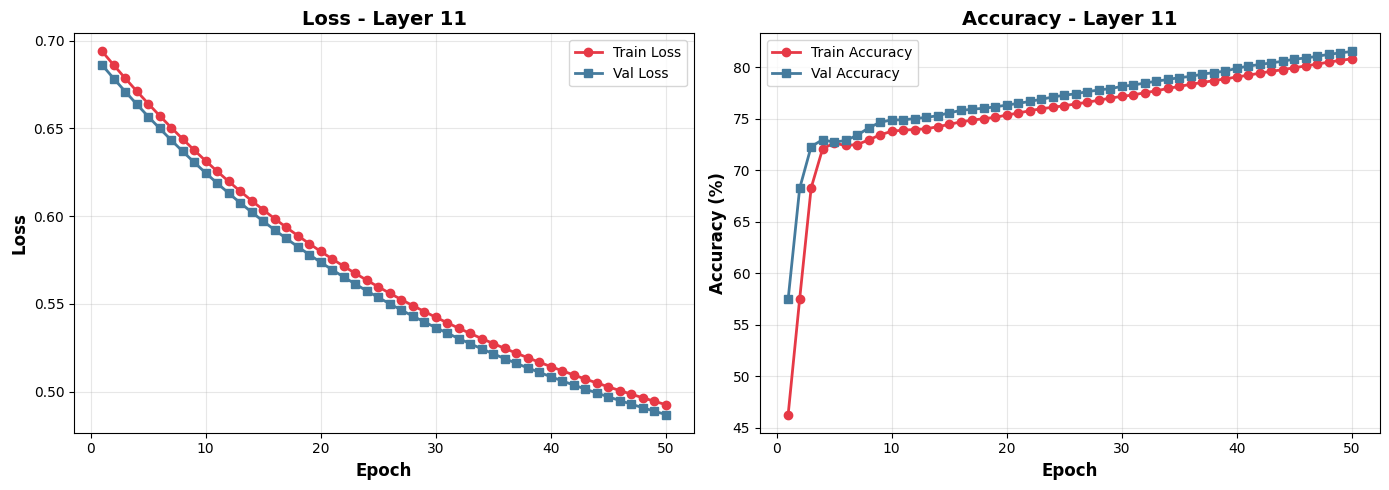

Layer 11:
  Best Val Acc: 81.52%
  Best Epoch: 50



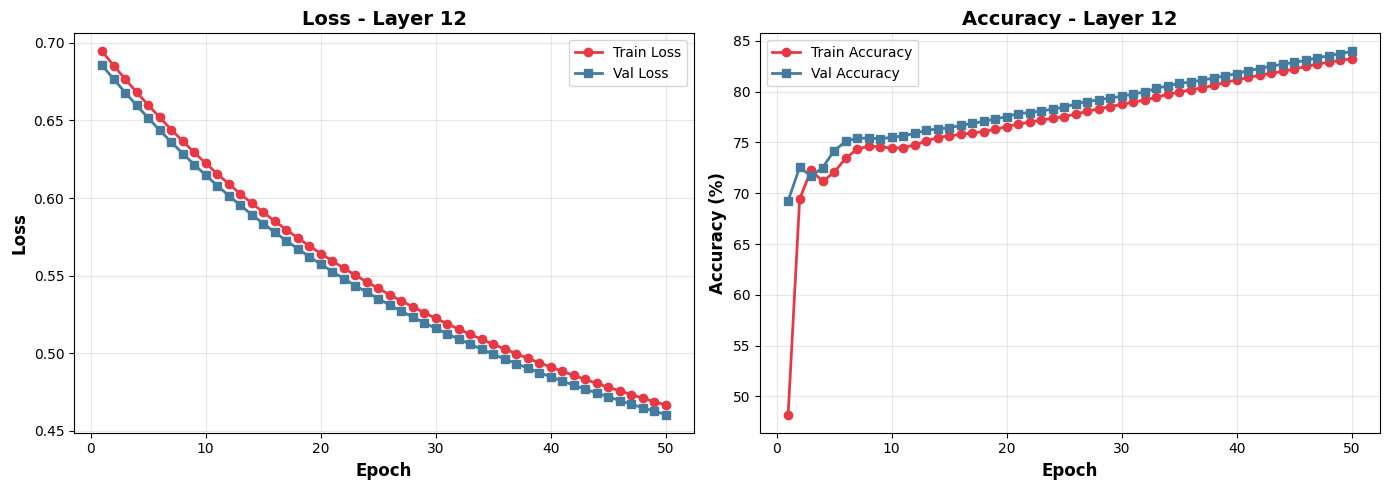

Layer 12:
  Best Val Acc: 83.95%
  Best Epoch: 50



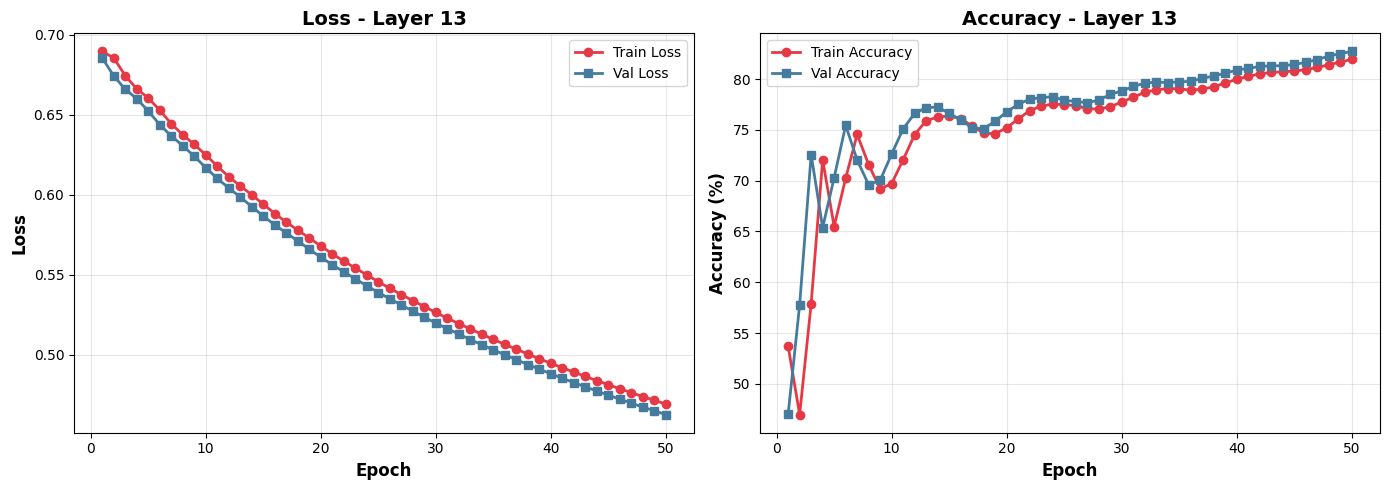

Layer 13:
  Best Val Acc: 82.71%
  Best Epoch: 50



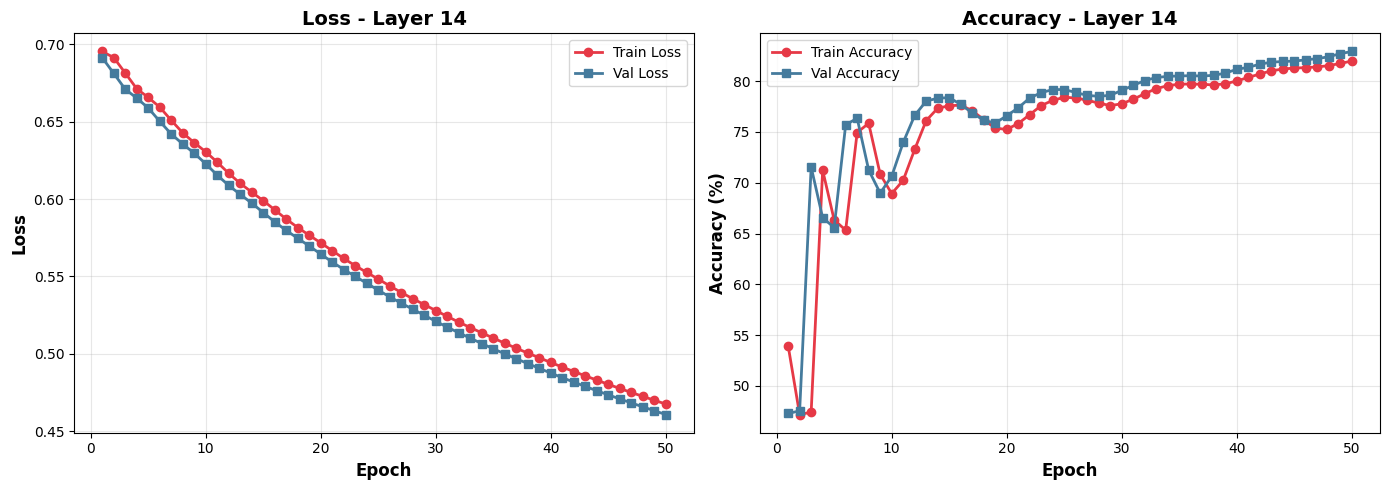

Layer 14:
  Best Val Acc: 82.92%
  Best Epoch: 50



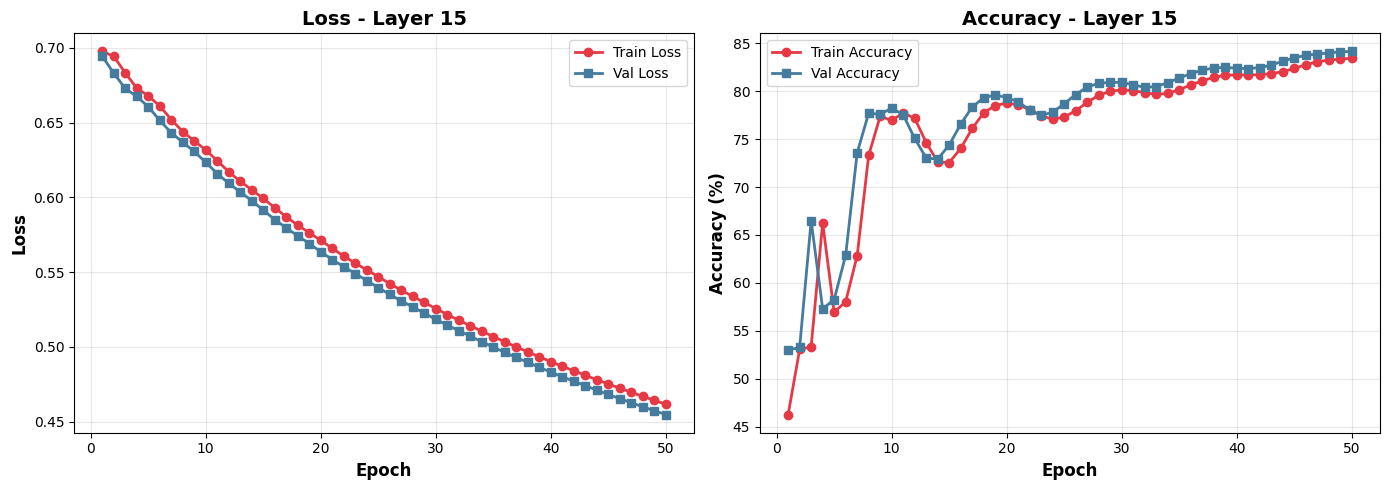

Layer 15:
  Best Val Acc: 84.15%
  Best Epoch: 50



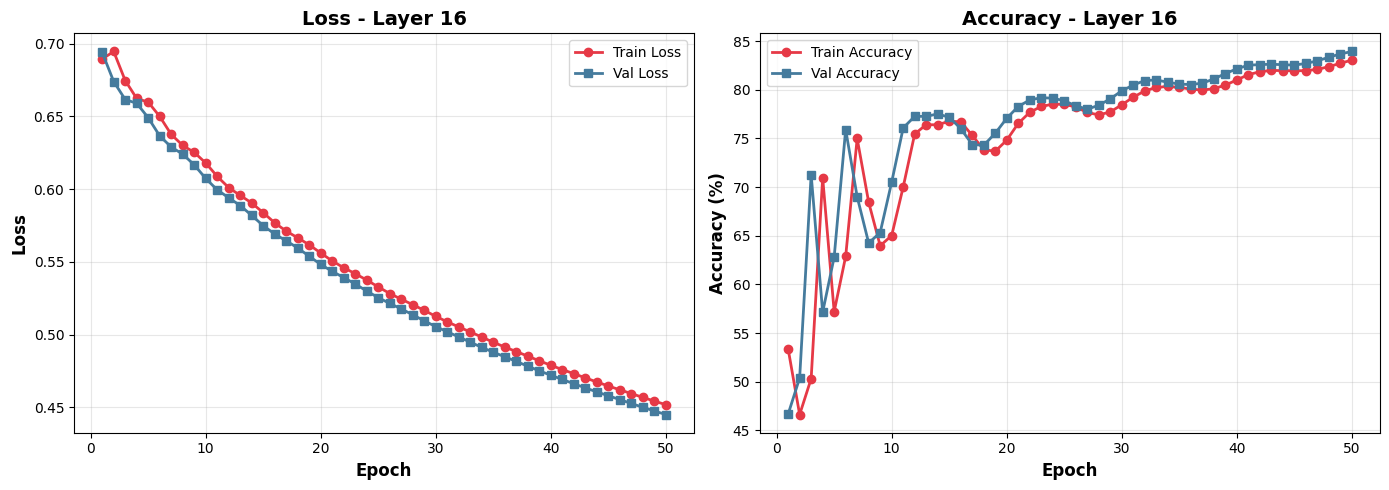

Layer 16:
  Best Val Acc: 83.93%
  Best Epoch: 50



In [9]:
import matplotlib.pyplot as plt

print("="*80)
print("📊 TRAINING CURVES")
print("="*80 + "\n")

# Plot for each layer
for layer_idx in sorted(layer_results.keys()):
    history = layer_results[layer_idx]['history']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(history['epoch'], history['train_loss'],
                 label='Train Loss', marker='o', linewidth=2, color='#E63946')
    axes[0].plot(history['epoch'], history['val_loss'],
                 label='Val Loss', marker='s', linewidth=2, color='#457B9D')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Loss - Layer {layer_idx}', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history['epoch'],
                [acc*100 for acc in history['train_acc']],
                label='Train Accuracy', marker='o', linewidth=2, color='#E63946')
    axes[1].plot(history['epoch'],
                [acc*100 for acc in history['val_acc']],
                label='Val Accuracy', marker='s', linewidth=2, color='#457B9D')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Accuracy - Layer {layer_idx}', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Layer {layer_idx}:")
    print(f"  Best Val Acc: {max(history['val_acc'])*100:.2f}%")
    print(f"  Best Epoch: {history['best_epoch']}\n")

# SECTION 9: Select Best Layer

In [10]:
print("="*80)
print("🏆 BEST LAYER SELECTION (F1-Based)")
print("="*80 + "\n")

print("📊 Results (sorted by F1 score):")
print(f"{'Layer':<8} {'Val Acc':<10} {'Val F1':<10}")
print("─"*30)

for layer_idx in sorted(layer_results.keys()):
    result = layer_results[layer_idx]
    print(f"{layer_idx:<8} {result['val_acc']*100:>6.2f}%   {result['val_f1']:>6.4f}")

# Select based on F1 score (better for imbalanced data)
best_layer = max(layer_results.keys(),
                 key=lambda k: layer_results[k]['val_f1'])
best_classifier = layer_results[best_layer]['classifier']
best_history = layer_results[best_layer]['history']

print(f"\n🏆 Selected: Layer {best_layer}")
print(f"   Val Accuracy: {layer_results[best_layer]['val_acc']*100:.2f}%")
print(f"   Val F1 Score: {layer_results[best_layer]['val_f1']:.4f}")
print("="*80 + "\n")

🏆 BEST LAYER SELECTION (F1-Based)

📊 Results (sorted by F1 score):
Layer    Val Acc    Val F1    
──────────────────────────────
11        81.52%   0.8152
12        83.95%   0.8394
13        82.71%   0.8271
14        82.92%   0.8291
15        84.15%   0.8414
16        83.93%   0.8392

🏆 Selected: Layer 15
   Val Accuracy: 84.15%
   Val F1 Score: 0.8414



# SECTION 10: Evaluate Best Classifier

In [11]:
print("="*80)
print("📊 FINAL COMPREHENSIVE EVALUATION")
print("="*80 + "\n")

# Evaluate best classifier
best_classifier.eval()
X_val = layer_activations[best_layer]['X_val']
y_val = layer_activations[best_layer]['y_val']

X_val_t = torch.FloatTensor(X_val).to(device)

with torch.no_grad():
    val_outputs = best_classifier(X_val_t)
    val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
    val_probs = torch.softmax(val_outputs, dim=1).cpu().numpy()

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

# Metrics
accuracy = accuracy_score(y_val, val_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    y_val, val_preds, average=None, labels=[0, 1]
)

print(f"Overall Accuracy: {accuracy*100:.2f}%\n")

print("Per-Class Metrics:")
print("─"*60)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support'}")
print("─"*60)
print(f"{'Biased':<12} {precision[0]:<12.4f} {recall[0]:<12.4f} {f1[0]:<12.4f} {support[0]}")
print(f"{'Unbiased':<12} {precision[1]:<12.4f} {recall[1]:<12.4f} {f1[1]:<12.4f} {support[1]}")
print("─"*60 + "\n")

# Confusion matrix
cm = confusion_matrix(y_val, val_preds)
print("Confusion Matrix:")
print(f"                 Predicted")
print(f"             Biased  Unbiased")
print(f"Actual Biased   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"       Unbiased {cm[1,0]:4d}    {cm[1,1]:4d}\n")

# ═══════════════════════════════════════════════════════════════════
# ✅ CHECK FOR DEGENERATE SOLUTION
# ═══════════════════════════════════════════════════════════════════
unique_preds, pred_counts = np.unique(val_preds, return_counts=True)

print("Prediction Distribution:")
for pred, count in zip(unique_preds, pred_counts):
    class_name = "Biased" if pred == 0 else "Unbiased"
    print(f"  {class_name}: {count} ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) == 1:
    print("\n❌ DEGENERATE SOLUTION DETECTED!")
    print(f"   Model only predicts class {unique_preds[0]}")
    print("   Training failed - model did not learn!")
elif cm[0,0] == 0 or cm[1,1] == 0:
    print("\n⚠️  WARNING: One class has 0% recall!")
    print("   Model may not be learning properly")
else:
    print("\n✅ Model predicts both classes!")
    print(f"   Biased recall: {recall[0]*100:.1f}%")
    print(f"   Unbiased recall: {recall[1]*100:.1f}%")

print("\n" + "="*80)

# Full classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val, val_preds,
                           target_names=['Biased', 'Unbiased'],
                           digits=4))

print("="*80 + "\n")

📊 FINAL COMPREHENSIVE EVALUATION

Overall Accuracy: 84.15%

Per-Class Metrics:
────────────────────────────────────────────────────────────
Class        Precision    Recall       F1-Score     Support
────────────────────────────────────────────────────────────
Biased       0.7840       0.9031       0.8394       6432
Unbiased     0.9058       0.7892       0.8435       7591
────────────────────────────────────────────────────────────

Confusion Matrix:
                 Predicted
             Biased  Unbiased
Actual Biased   5809     623
       Unbiased 1600    5991

Prediction Distribution:
  Biased: 7409 (52.8%)
  Unbiased: 6614 (47.2%)

✅ Model predicts both classes!
   Biased recall: 90.3%
   Unbiased recall: 78.9%


Detailed Classification Report:
              precision    recall  f1-score   support

      Biased     0.7840    0.9031    0.8394      6432
    Unbiased     0.9058    0.7892    0.8435      7591

    accuracy                         0.8415     14023
   macro avg     0.844

# SECTION 11: Save Model Locally

In [16]:
print("="*80)
print("💾 SAVING MODEL LOCALLY")
print("="*80 + "\n")

os.makedirs(config.local_save_dir, exist_ok=True)

# Save model weights
model_path = os.path.join(config.local_save_dir, "pytorch_model.bin")
torch.save(best_classifier.state_dict(), model_path)
print(f"✅ Model: {model_path}")

# Save config
model_config = {
    'model_type': 'BADClassifier',
    'input_dim': hidden_size,
    'output_dim': 2,
    'hidden_size': hidden_size,
    'target_layer': best_layer,
    'num_layers': num_layers,
    'base_model_name': config.base_model_name,
    'label_mapping': {'biased': 0, 'unbiased': 1},
    'dataset_info': {
        'bbq_samples': config.num_bbq_samples,
        'mmlu_samples': config.num_mmlu_samples,
        'bbq_source': config.bbq_dataset_name,
        'mmlu_source': config.mmlu_dataset_name
    },
    'layer_selection': {
        'candidates': candidate_layers,
        'selected': best_layer,
        'accuracies': {k: float(v['val_acc']) for k, v in layer_results.items()}
    },
    'performance': {
        # 'best_val_acc': float(best_accuracy),
        'best_epoch': int(best_history['best_epoch'])
    },
    'trained_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

config_path = os.path.join(config.local_save_dir, "config.json")
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"✅ Config: {config_path}")

# Save history
history_path = os.path.join(config.local_save_dir, "training_history.json")
histories = {str(k): v['history'] for k, v in layer_results.items()}
with open(history_path, 'w') as f:
    json.dump(histories, f, indent=2)
print(f"✅ History: {history_path}")

# README
readme = f"""# BAD Classifier for {config.base_model_name}

## Model Details
- **Detection Layer**: {best_layer}

- **Dataset**: BBQ ({config.num_bbq_samples}) + MMLU ({config.num_mmlu_samples})

## Layer Performance
{chr(10).join([f'- Layer {k}: {v["val_acc"]*100:.2f}%' for k, v in sorted(layer_results.items())])}

## Usage
```python
from huggingface_hub import hf_hub_download
import torch
import json

# Download
config_path = hf_hub_download("{config.hf_repo_name}", "config.json")
model_path = hf_hub_download("{config.hf_repo_name}", "pytorch_model.bin")

# Load config
with open(config_path) as f:
    config = json.load(f)

# Define classifier
class BADClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 2)
    def forward(self, x):
        return self.linear(x)

# Load
classifier = BADClassifier(config['input_dim'])
classifier.load_state_dict(torch.load(model_path))
```

## Citation
```bibtex
@article{{fairsteer2025,
  title={{FairSteer: Inference Time Debiasing for LLMs}},
  author={{Li, Yichen et al.}},
  year={{2025}}
}}
```
"""

readme_path = os.path.join(config.local_save_dir, "README.md")
with open(readme_path, 'w') as f:
    f.write(readme)
print(f"✅ README: {readme_path}")

print("\n" + "="*80 + "\n")


💾 SAVING MODEL LOCALLY

✅ Model: ./bad_model_fixed/pytorch_model.bin
✅ Config: ./bad_model_fixed/config.json
✅ History: ./bad_model_fixed/training_history.json
✅ README: ./bad_model_fixed/README.md




# SECTION 12: Upload to HuggingFace Hub

In [18]:
print("="*80)
print("☁️  UPLOADING TO HUGGINGFACE HUB")
print("="*80 + "\n")

print("⚠️  Login required!")
print("Run: from huggingface_hub import login; login()\n")

try:
    # Login (user needs to provide token)
    login()
    print("✅ Logged in\n")

    # Create repo
    api = HfApi()
    repo_url = create_repo(
        repo_id=config.hf_repo_name,
        private=config.hf_private,
        exist_ok=True
    )
    print(f"✅ Repository: {repo_url}\n")

    # Upload files
    files = ["pytorch_model.bin", "config.json", "training_history.json", "README.md"]

    print("Uploading files...")
    for filename in files:
        local_path = os.path.join(config.local_save_dir, filename)
        print(f"  → {filename}")

        api.upload_file(
            path_or_fileobj=local_path,
            path_in_repo=filename,
            repo_id=config.hf_repo_name
        )

    print(f"\n✅ Upload complete!")
    print(f"   View at: https://huggingface.co/{config.hf_repo_name}")

except Exception as e:
    print(f"⚠️  Upload failed: {e}")
    print(f"   Model saved locally at: {config.local_save_dir}")
    print(f"   You can upload manually later")

print("\n" + "="*80)
print("✅ TRAINING PIPELINE COMPLETE")
print("="*80)
print(f"\n📊 Summary:")
print(f"   Dataset: BBQ + MMLU")
print(f"   Best Layer: {best_layer}")

print(f"   Saved: {config.local_save_dir}")
print(f"   HF Repo: {config.hf_repo_name}")
print("="*80 + "\n")

☁️  UPLOADING TO HUGGINGFACE HUB

⚠️  Login required!
Run: from huggingface_hub import login; login()



✅ Logged in

✅ Repository: https://huggingface.co/bitlabsdb/bad-classifier-tinyllama

Uploading files...
  → pytorch_model.bin


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...l_fixed/pytorch_model.bin: 100%|##########| 18.4kB / 18.4kB            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


  → config.json


No files have been modified since last commit. Skipping to prevent empty commit.


  → training_history.json
  → README.md


/usr/local/lib/python3.12/dist-packages/huggingface_hub/hf_api.py:9662: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
No files have been modified since last commit. Skipping to prevent empty commit.



✅ Upload complete!
   View at: https://huggingface.co/bitlabsdb/bad-classifier-tinyllama

✅ TRAINING PIPELINE COMPLETE

📊 Summary:
   Dataset: BBQ + MMLU
   Best Layer: 15
   Saved: ./bad_model_fixed
   HF Repo: bitlabsdb/bad-classifier-tinyllama

